# Read SUMMA output

In [53]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper', font_scale=1.25)
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics/fingerprints'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [3]:
def evalBiasTs(ax, dsDict, obs, labels, ls, lcolor):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    for ex in sorted(dsDict.keys()):
        ax.plot(dsDict[ex].scalarSurfaceTemp - 273.15, obs.Tsrf, '.',
                label=labels[ex],
                color=lcolor[ex])
    ax.plot([-30, 0], [-30, 0], 'k--')
    ax.set_xlim(-30, 0)
    ax.set_ylim(-30, 0)
    ax.set_xlabel('Modeled T ($^{\circ}$)')
    ax.set_ylabel('Observed T ($^{\circ}$)')
    ax.legend(loc='best')

def sortFun(s):
    if 'high' in s and 'L' in s:
        return(4)
    elif 'high' in s and 'S' in s:
        return(3)
    elif 'low' in s and 'S' in s:
        return(2)
    elif 'low' in s and 'L' in s:
        return(1)
    

## Grab data: observations and model output

In [4]:
# ----------
# Sites and forcing data
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = {'CDP': datetime(2002, 10, 1), 'SWA': datetime(2006, 10, 1)}
d2 = {'CDP': datetime(2010, 9, 30, 22, 0, 0), 'SWA': datetime(2012, 9, 30, 23, 0, 0)}

os.chdir(dirData)
CDPforce = xr.open_dataset('CDP.ModTsfc.nc')
CDPforce = CDPforce.loc[dict(time = slice(d1['CDP'], d2['CDP']))]
CDPforce_daily = CDPforce.resample(how='mean', freq='d', dim='time')

SWAforce = xr.open_dataset('SWA.ModTsfc.nc')
SWAforce = SWAforce.loc[dict(time = slice(d1['SWA'], d2['SWA']))]
SWAforce_daily = SWAforce.resample(how='mean', freq='d', dim='time')

# ----------
# Summa modeling results for each site
os.chdir(dirData  + '/summaResults')

SWA = xr.open_dataset('SWA.summaResults.forcing.nc')
SWA = xr.concat([SWA, xr.open_dataset('SWA.summaResults.internal.nc')], 'expID')
print(SWA)

CDP = xr.open_dataset('CDP.summaResults.forcing.nc')
CDP = xr.concat([CDP, xr.open_dataset('CDP.summaResults.internal.nc')], 'expID')
print(CDP)

<xarray.Dataset>
Dimensions:                (expID: 45, time: 52608)
Coordinates:
  * time                   (time) datetime64[ns] 2006-10-01 ...
    exp                    (expID) object 'longwaveBias' 'longwaveBias' ...
    family                 (expID) object 'lowLW' 'lowLW' 'highLW' 'highLW' ...
  * expID                  (expID) object 'lowLW_L' 'lowLW_S' 'highLW_S' ...
Data variables:
    scalarRainPlusMelt     (expID, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (expID, time) float64 1.784e-07 3.584e-09 0.0 0.0 ...
    scalarSurfaceRunoff    (expID, time) float64 3.338e-12 7.387e-14 0.0 0.0 ...
    scalarSurfaceTemp      (expID, time) float64 283.1 280.9 279.7 278.8 ...
    scalarSenHeatTotal     (expID, time) float64 -75.53 -20.79 -19.85 -15.34 ...
    scalarLatHeatTotal     (expID, time) float64

In [5]:
def snowPresence(ds, obs):
    snowPresenceArray = (obs.SP == 1) & (ds['scalarSWE'] > 0) & (ds['scalarSurfaceTemp'] < 273.2)
    return(snowPresenceArray)

def createSnowSurfTemp(ds):
    snowTempArray = ds['scalarSurfaceTemp'].where((ds['scalarSWE'] > 0) & (ds['scalarSurfaceTemp'] < 273.2))
    return(snowTempArray)

# snow surface temperature and snow presence
SWA['SP'] = snowPresence(SWA, SWAforce)
SWA['scalarSnowTemp'] = createSnowSurfTemp(SWA)
CDP['SP'] = snowPresence(CDP, CDPforce)
CDP['scalarSnowTemp'] = createSnowSurfTemp(CDP)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [7]:
# ----------
# Experiment names - Structure Uncertainty
experiments = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias', 'layers',
               'thermalCond', 'stability']
expMetUnc = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias']
expIntern = ['layers', 'thermalCond', 'stability']
experimentType = {'forcing': expMetUnc, 'internal': expIntern}
force = {'SWA': SWAforce, 'CDP': CDPforce}
results = {'SWA': SWA, 'CDP': CDP}

# ----------
# Met uncertainty experiment IDs and values
expNames = {'longwaveBias': ['lowLW_L','lowLW_S', 'highLW_S', 'highLW_L']}
expBias = {'longwaveBias': {'lowLW_L': -25, 'lowLW_S': -10, 'highLW_S': 10, 'highLW_L': 25}}

expNames['shortwaveBias'] = ['lowSW_L','lowSW_S', 'highSW_S', 'highSW_L']
expBias['shortwaveBias'] = {'lowSW_L': -80, 'lowSW_S': -30, 'highSW_S': 30, 'highSW_L': 80}

expNames['specHumidBias'] = ['lowQS_L','lowQS_S', 'highQS_S', 'highQS_L']
expBias['specHumidBias'] = {'lowQS_L': -25,  'lowQS_S': -10, 'highQS_S': 10, 'highQS_L': 25}

expNames['airTempBias'] = ['lowTair_L','lowTair_S', 'highTair_S', 'highTair_L']
expBias['airTempBias'] = {'lowTair_L': -3, 'lowTair_S': -1.5, 'highTair_S': 1.5, 'highTair_L': 3}

expNames['windBias'] = ['lowU_L','lowU_S', 'highU_S', 'highU_L']
expBias['windBias'] = {'lowU_L': -3, 'lowU_S': -1.5, 'highU_S': 1.5, 'highU_L': 3}

metName = {'longwaveBias': 'LWRadAtm',
           'shortwaveBias': 'SWRadAtm',
           'specHumidBias': 'spechum',
           'airTempBias': 'airtemp',
           'windBias': 'windspd'}

metNameTitle = {'longwaveBias': 'Longwave Bias (Wm$^{-2}$)',
           'shortwaveBias': 'Shortwave Bias (Wm$^{-2}$)',
           'specHumidBias': 'Relative Humiditiy Bias (%)',
           'airTempBias': 'Air Temperature Bias ($^{\circ}$C)',
           'windBias': 'Wind Speed Bias (m s$^{-1}$)'}

# ----------
# Layer
expNames['layers'] = ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']

# Thermal conductivity
arrayNames = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayAppend = ['Mid', 'Low', 'High']
expNames['thermalCond'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

# Stability
arrayAppend = ['Low', 'Mid', 'High']
arrayNames = ['standard', 'louisinv', 'mahrtexp']
expNames['stability'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

internalNames = {'stability': ['standard', 'louisinv', 'mahrtexp'],
                 'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010'],
                 'thermalCond': ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']}
internalLabels = {'layers': {'layerThin': 'UEB', 'layerThick': 'VIC', 'jrdn1991': 'SNTHERM', 'CLM_2010': 'CLM'},
                  'stability': {'standard': 'Anderson', 'louisinv': 'Louis', 'mahrtexp': 'Mahrt'},
                  'thermalCond': {'tyen1965': 'Yen', 'melr1977': 'Mellor',
                                  'jrdn1991': 'Jordan', 'smnv2000': 'Smirnova'}}
internalTitles = {'layers': 'a) Vertical Structure',
                  'stability': 'b) Stability Correction',
                  'thermalCond': 'c) Thermal Conductivity'}

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

In [8]:
# Grab forcing data values for the met uncertainty experiments
for s in siteNames:
    tempDat = {}
    for s in siteNames:
        for expN in expMetUnc:
            if expN == 'precipBias':
                continue
            os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/input/'
                     + expN + '/' + s + '/')

            # Experiment specific files
            for n, expID in enumerate(expNames[expN]):
                tempDatName = s + '.ModTsfc.ModelForcing.' + expID + '.nc'
                fieldForBias = metName[expN]
                tempDat[expID] = xr.open_dataset(tempDatName)

        resultsDataSet = xr.concat([tempDat[scen] for exp in expMetUnc for scen in expNames[exp]], dim='expID')
        resultsDataSet.coords['expID'] = list([n for exp in expMetUnc for n in expNames[exp]])
        # Recreate time series since summa's time format does not play well with datetime
        resultsDataSet['time'] = pd.date_range(d1[s], d2[s], freq='H')

        # Add to the results DataSet
        resultsDataSet = resultsDataSet.reindex_like(results[s]).squeeze()
        for expN in expMetUnc:
            fieldForBias = metName[expN]
            results[s][fieldForBias] = (('expID', 'time'), resultsDataSet[fieldForBias])

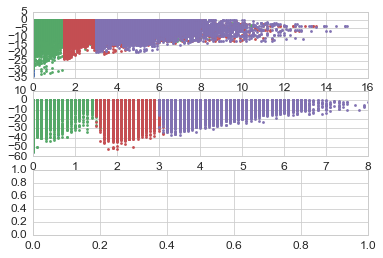

In [9]:
fig, axes = plt.subplots(3, 1)
for exp in expNames['windBias']:
    ax = axes[0]
    ds = CDP.sel(expID=exp)
    ax.plot(ds.windspd, ds.scalarSnowTemp - 273.15, '.')
    
    ax = axes[1]
    ds = SWA.sel(expID=exp)
    ax.plot(ds.windspd, ds.scalarSnowTemp - 273.15, '.')

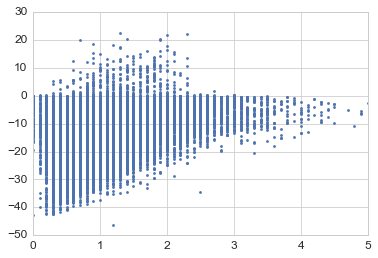

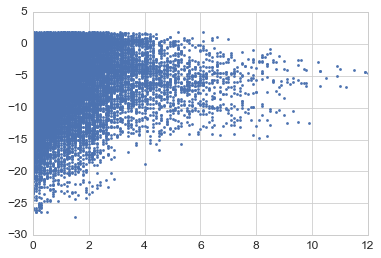

In [10]:
plt.figure()
plt.plot(SWAforce.WIND, SWAforce.snowTs, '.')

plt.figure()
plt.plot(CDPforce.WIND, CDPforce.snowTs, '.')


There doesn't appear to be any sort of obvious signal in wind speed vs surface temperature or wind speed vs bias in surface temperature. Still need to check things like day vs night and explicitly examine low vs high wind conditions.

I want to recreate the Figure 3 from Pomeroy et al., 2016, but with real data

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


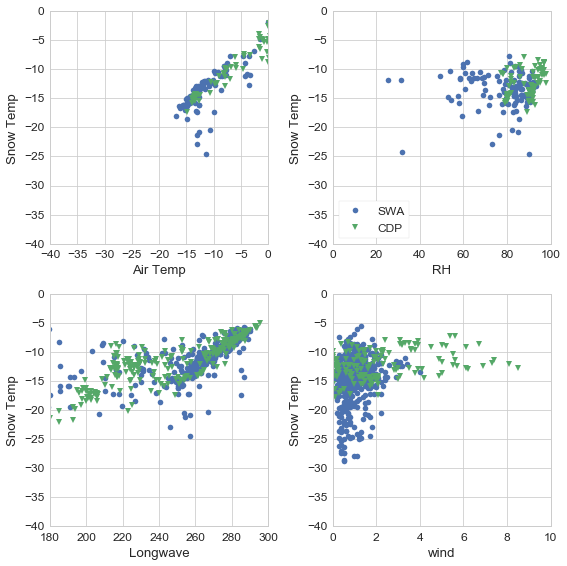

In [11]:
# Air temp
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()[0]
ds = SWAforce.where((SWAforce.SWdwn < 10)
                    & (SWAforce.RH < 90)  & (SWAforce.RH > 70)
                    & (SWAforce.LWdwn > 240) & (SWAforce.LWdwn < 260)
                    & (SWAforce.WIND > 1.5) & (SWAforce.WIND < 2.5))
ax.plot(ds.Tair, ds.snowTs, 'o')
ds = CDPforce.where((CDPforce.SWdwn < 10)
                    & (CDPforce.LWdwn > 240) & (CDPforce.LWdwn < 260)
                    & (CDPforce.HUMREL < 90)  & (CDPforce.HUMREL > 70)
                    & (CDPforce.WIND > 1.5) & (CDPforce.WIND < 2.5))
ax.plot(ds.Tair, ds.snowTs, 'v')
ax.set_xlim(-40, 0)
ax.set_xlabel('Air Temp')
ax.set_ylim(-40, 0)
ax.set_ylabel('Snow Temp')

# RH
ax = axes.flatten()[1]
ds = SWAforce.where((SWAforce.SWdwn < 10)
                    & (SWAforce.Tair > -15) & (SWAforce.Tair < -5)
                    & (SWAforce.LWdwn > 240) & (SWAforce.LWdwn < 260)
                    & (SWAforce.WIND > 1.5) & (SWAforce.WIND < 2.5))
ax.plot(ds.RH, ds.snowTs, 'o', label='SWA')
ds = CDPforce.where((CDPforce.SWdwn < 10)
                    & (CDPforce.Tair > -15) & (CDPforce.Tair < -5)
                    & (CDPforce.LWdwn > 240) & (CDPforce.LWdwn < 260)
                    & (CDPforce.WIND > 1.5) & (CDPforce.WIND < 2.5))
ax.plot(ds.HUMREL, ds.snowTs, 'v', label='CDP')
ax.set_xlim(0, 100)
ax.set_ylim(-40, 0)
ax.set_xlabel('RH')
ax.set_ylabel('Snow Temp')
ax.legend(loc='lower left', frameon=True)

# Longwave
ax = axes.flatten()[2]
ds = SWAforce.where((SWAforce.SWdwn < 10)
                    & (SWAforce.Tair > -15) & (SWAforce.Tair < -5)
                    & (SWAforce.RH < 90)  & (SWAforce.RH > 70)
                    & (SWAforce.WIND > 1.5) & (SWAforce.WIND < 2.5))
ax.plot(ds.LWdwn, ds.snowTs, 'o')
ds = CDPforce.where((CDPforce.SWdwn < 10)
                    & (CDPforce.Tair > -15) & (CDPforce.Tair < -5)
                    & (CDPforce.HUMREL < 90)  & (CDPforce.HUMREL > 70)
                    & (CDPforce.WIND > 1.5) & (CDPforce.WIND < 2.5))
ax.plot(ds.LWdwn, ds.snowTs, 'v')
ax.set_xlim(180, 300)
ax.set_ylim(-40, 0)
ax.set_xlabel('Longwave')
ax.set_ylabel('Snow Temp')

# Wind
ax = axes.flatten()[3]
ds = SWAforce.where((SWAforce.SWdwn < 10)
                    & (SWAforce.Tair > -15) & (SWAforce.Tair < -5)
                    & (SWAforce.LWdwn > 240) & (SWAforce.LWdwn < 260)
                    & (SWAforce.RH < 90)  & (SWAforce.RH > 70))
ax.plot(ds.WIND, ds.snowTs, 'o')
ds = CDPforce.where((CDPforce.SWdwn < 10)
                    & (CDPforce.Tair > -15) & (CDPforce.Tair < -5)
                    & (CDPforce.LWdwn > 240) & (CDPforce.LWdwn < 260)
                    & (CDPforce.HUMREL < 90)  & (CDPforce.HUMREL > 70))
ax.plot(ds.WIND, ds.snowTs, 'v')
ax.set_xlim(0, 10)
ax.set_ylim(-40, 0)
ax.set_xlabel('wind')
ax.set_ylabel('Snow Temp')

fig.tight_layout()
os.chdir(dirPrint)
fig.savefig('pomeroy2016.withData.pdf')

Pomeroy is on to a relevant point with his model, even though he doesn't quite complete the thought. At night, the surface temperature is dominated by the longwave irradiance during low wind conditions and by turbulence during high wind conditions. Let's see if I can tease that apart. 

## Create bias fields


In [81]:
results_daily = {}
for s in siteNames:
    # Bias
    results[s]['bias'] = results[s].scalarSnowTemp - 273.15 - force[s].snowTs

    # Bias in min daily
    dsMin = results[s].scalarSnowTemp.resample(how='min', dim='time', freq='d')
    dsMinBias = (dsMin - 273.15) - force[s].snowTs.resample(how='min', dim='time', freq='d')

    # Bias in max daily
    dsMax = results[s].scalarSnowTemp.resample(how='max', dim='time', freq='d')
    dsMaxBias =  dsMax - 273.15 - force[s].snowTs.resample(how='max', dim='time', freq='d')

    # Diurnal range
    dsAmp = dsMax - dsMin
    # Diurnal amplitude of observed Ts
    diurnalTs = (force[s].snowTs.resample(how='max', dim='time', freq='d')
                 - force[s].snowTs.resample(how='min', dim='time', freq='d'))
        
    # Assign to DataSet
    results_daily[s] = results[s].resample(how='mean', dim='time', freq='d')
    results_daily[s]['biasAmp'] = dsAmp - diurnalTs
    results_daily[s]['diurnalTs'] = dsAmp
    results_daily[s]['biasMin'] = dsMin
    results_daily[s]['biasMax'] = dsMax


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


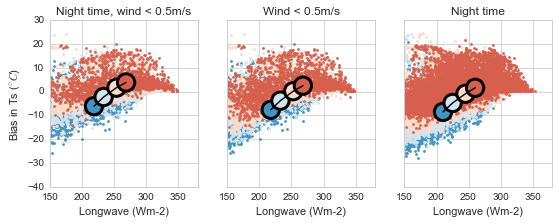

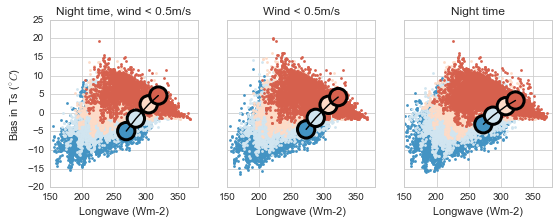

In [78]:
for s in siteNames:
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

    # Plot Ts vs LWdwn for night, low wind conditions
    # Use 1.5m/s as this places us solidly within regime 1 turbulence in the absence of wave-breaking
    ax = axes.flatten()[0]
    ds = results[s].where((results[s].SWRadAtm < 10) & (results[s].windspd < .5))
    ds = ds.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias').swap_dims({'exp': 'expID'})
    for n, expID in enumerate(ds.expID):
        ax.plot(ds.sel(expID=expID).LWRadAtm,
                (ds.sel(expID=expID).scalarSnowTemp - 273) - force[s].snowTs,
                '.', color=sns.color_palette('RdBu_r', 4)[n])
    # mean values
    ax.scatter(ds.LWRadAtm.mean(dim='time'),
               ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
               s=300, c=sns.color_palette('RdBu_r', 4), edgecolor='black', linewidth='3', zorder=10)
    ax.plot(ds.LWRadAtm.mean(dim='time'),
            ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
            '-k', zorder=11)
    ax.set_xlim(150, 380)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_ylabel('Bias in Ts ($^{\circ} C$)')
    ax.set_title('Night time, wind < 0.5m/s')

    # Plot Ts vs LWdwn for just low wind conditions
    ax = axes.flatten()[1]
    ds = results[s].where((results[s].windspd < .5))
    ds = ds.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias').swap_dims({'exp': 'expID'})
    for n, expID in enumerate(ds.expID):
        ax.plot(ds.sel(expID=expID).LWRadAtm,
                (ds.sel(expID=expID).scalarSnowTemp - 273) - force[s].snowTs,
                '.', color=sns.color_palette('RdBu_r', 4)[n])
    # mean values
    ax.scatter(ds.LWRadAtm.mean(dim='time'),
               ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
               s=300, c=sns.color_palette('RdBu_r', 4), edgecolor='black', linewidth='3', zorder=10)
    ax.plot(ds.LWRadAtm.mean(dim='time'),
            ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
            '-k', zorder=11)
    ax.set_xlim(150, 380)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_title('Wind < 0.5m/s')

    # Plot Ts vs LWdwn for just low night time
    ax = axes.flatten()[2]
    ds = results[s].where((results[s].SWRadAtm < 10))
    ds = ds.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias').swap_dims({'exp': 'expID'})
    for n, expID in enumerate(ds.expID):
        ax.plot(ds.sel(expID=expID).LWRadAtm,
                (ds.sel(expID=expID).scalarSnowTemp - 273) - force[s].snowTs,
                '.', color=sns.color_palette('RdBu_r', 4)[n])
    # mean values
    ax.scatter(ds.LWRadAtm.mean(dim='time'),
               ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
               s=300, c=sns.color_palette('RdBu_r', 4), edgecolor='black', linewidth='3', zorder=10)
    ax.plot(ds.LWRadAtm.mean(dim='time'),
            ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
            '-k', zorder=11)
    ax.set_xlim(150, 380)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_title('Night time')


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


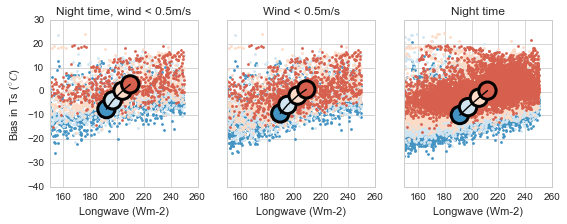

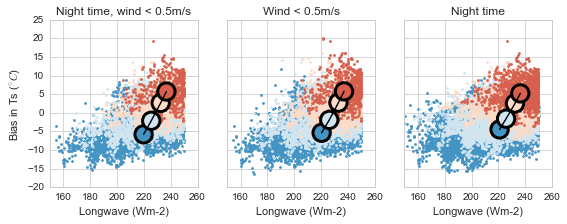

In [82]:
for s in siteNames:
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

    # Plot Ts vs LWdwn for night, low wind conditions
    # Use 1.5m/s as this places us solidly within regime 1 turbulence in the absence of wave-breaking
    ax = axes.flatten()[0]
    ds = results[s].where((results[s].SWRadAtm < 10) & (results[s].windspd < .5) & (results[s].LWRadAtm < 250))
    ds = ds.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias').swap_dims({'exp': 'expID'})
    for n, expID in enumerate(ds.expID):
        ax.plot(ds.sel(expID=expID).LWRadAtm,
                (ds.sel(expID=expID).scalarSnowTemp - 273) - force[s].snowTs,
                '.', color=sns.color_palette('RdBu_r', 4)[n])
    # mean values
    ax.scatter(ds.LWRadAtm.mean(dim='time'),
               ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
               s=300, c=sns.color_palette('RdBu_r', 4), edgecolor='black', linewidth='3', zorder=10)
    ax.plot(ds.LWRadAtm.mean(dim='time'),
            ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
            '-k', zorder=11)
    ax.set_xlim(150, 260)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_ylabel('Bias in Ts ($^{\circ} C$)')
    ax.set_title('Night time, wind < 0.5m/s')

    # Plot Ts vs LWdwn for just low wind conditions
    ax = axes.flatten()[1]
    ds = results[s].where((results[s].windspd < .5) & (results[s].LWRadAtm < 250))
    ds = ds.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias').swap_dims({'exp': 'expID'})
    for n, expID in enumerate(ds.expID):
        ax.plot(ds.sel(expID=expID).LWRadAtm,
                (ds.sel(expID=expID).scalarSnowTemp - 273) - force[s].snowTs,
                '.', color=sns.color_palette('RdBu_r', 4)[n])
    # mean values
    ax.scatter(ds.LWRadAtm.mean(dim='time'),
               ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
               s=300, c=sns.color_palette('RdBu_r', 4), edgecolor='black', linewidth='3', zorder=10)
    ax.plot(ds.LWRadAtm.mean(dim='time'),
            ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
            '-k', zorder=11)
    ax.set_xlim(150, 260)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_title('Wind < 0.5m/s')

    # Plot Ts vs LWdwn for just low night time
    ax = axes.flatten()[2]
    ds = results[s].where((results[s].SWRadAtm < 10) & (results[s].LWRadAtm < 250))
    ds = ds.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias').swap_dims({'exp': 'expID'})
    for n, expID in enumerate(ds.expID):
        ax.plot(ds.sel(expID=expID).LWRadAtm,
                (ds.sel(expID=expID).scalarSnowTemp - 273) - force[s].snowTs,
                '.', color=sns.color_palette('RdBu_r', 4)[n])
    # mean values
    ax.scatter(ds.LWRadAtm.mean(dim='time'),
               ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
               s=300, c=sns.color_palette('RdBu_r', 4), edgecolor='black', linewidth='3', zorder=10)
    ax.plot(ds.LWRadAtm.mean(dim='time'),
            ((ds.scalarSnowTemp - 273) - force[s].snowTs).mean(dim='time'),
            '-k', zorder=11)
    ax.set_xlim(150, 260)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_title('Night time')


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


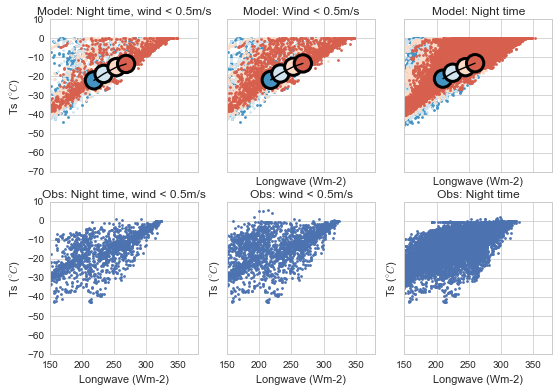

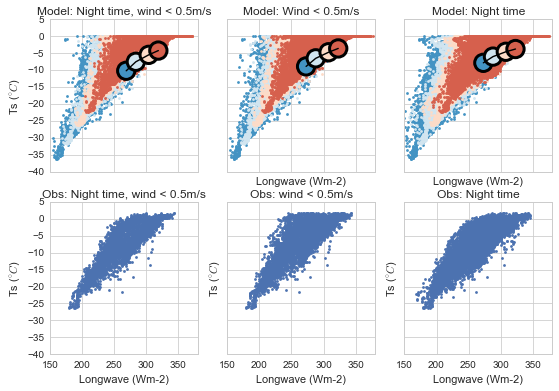

In [92]:
for s in siteNames:
    fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharey=True, sharex=True)

    # Plot Ts vs LWdwn for night, low wind conditions
    # Use 1.5m/s as this places us solidly within regime 1 turbulence in the absence of wave-breaking
    ax = axes[0, 0]
    ds = results[s].where((results[s].SWRadAtm < 10) & (results[s].windspd < .5))
    ds = ds.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias').swap_dims({'exp': 'expID'})
    for n, expID in enumerate(ds.expID):
        ax.plot(ds.sel(expID=expID).LWRadAtm,
                (ds.sel(expID=expID).scalarSnowTemp - 273),
                '.', color=sns.color_palette('RdBu_r', 4)[n])
    # mean values
    ax.scatter(ds.LWRadAtm.mean(dim='time'),
               ((ds.scalarSnowTemp - 273)).mean(dim='time'),
               s=300, c=sns.color_palette('RdBu_r', 4), edgecolor='black', linewidth='3', zorder=10)
    ax.plot(ds.LWRadAtm.mean(dim='time'),
            ((ds.scalarSnowTemp - 273)).mean(dim='time'),
            '-k', zorder=11)
    ax.set_ylabel('Ts ($^{\circ} C$)')
    ax.set_title('Model: Night time, wind < 0.5m/s')
    # Observed values
    ax = axes[1, 0]
    ax.plot(force[s].LWdwn.where((force[s].SWdwn < 10) & (force[s].WIND < .5)),
            force[s].snowTs.where((force[s].SWdwn < 10) & (force[s].WIND < .5)), '.')
    ax.set_xlim(150, 380)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_ylabel('Ts ($^{\circ} C$)')
    ax.set_title('Obs: Night time, wind < 0.5m/s')

    # Plot Ts vs LWdwn for just low wind conditions
    ax = axes.flatten()[1]
    ds = results[s].where((results[s].windspd < .5))
    ds = ds.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias').swap_dims({'exp': 'expID'})
    for n, expID in enumerate(ds.expID):
        ax.plot(ds.sel(expID=expID).LWRadAtm,
                (ds.sel(expID=expID).scalarSnowTemp - 273),
                '.', color=sns.color_palette('RdBu_r', 4)[n])
    # mean values
    ax.scatter(ds.LWRadAtm.mean(dim='time'),
               ((ds.scalarSnowTemp - 273)).mean(dim='time'),
               s=300, c=sns.color_palette('RdBu_r', 4), edgecolor='black', linewidth='3', zorder=10)
    ax.plot(ds.LWRadAtm.mean(dim='time'),
            ((ds.scalarSnowTemp - 273)).mean(dim='time'),
            '-k', zorder=11)
    ax.set_xlim(150, 380)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_title('Model: Wind < 0.5m/s')
    # Observed values
    ax = axes[1, 1]
    ax.plot(force[s].LWdwn.where((force[s].WIND < .5)),
            force[s].snowTs.where((force[s].WIND < .5)), '.')
    ax.set_xlim(150, 380)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_ylabel('Ts ($^{\circ} C$)')
    ax.set_title('Obs: wind < 0.5m/s')
    
    # Plot Ts vs LWdwn for just low night time
    ax = axes.flatten()[2]
    ds = results[s].where((results[s].SWRadAtm < 10))
    ds = ds.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias').swap_dims({'exp': 'expID'})
    for n, expID in enumerate(ds.expID):
        ax.plot(ds.sel(expID=expID).LWRadAtm,
                (ds.sel(expID=expID).scalarSnowTemp - 273),
                '.', color=sns.color_palette('RdBu_r', 4)[n])
    # mean values
    ax.scatter(ds.LWRadAtm.mean(dim='time'),
               ((ds.scalarSnowTemp - 273)).mean(dim='time'),
               s=300, c=sns.color_palette('RdBu_r', 4), edgecolor='black', linewidth='3', zorder=10)
    ax.plot(ds.LWRadAtm.mean(dim='time'),
            ((ds.scalarSnowTemp - 273)).mean(dim='time'),
            '-k', zorder=11)
    ax.set_xlim(150, 380)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_title('Model: Night time')
    # Observed values
    ax = axes[1, 2]
    ax.plot(force[s].LWdwn.where((force[s].SWdwn < 10)),
            force[s].snowTs.where((force[s].SWdwn < 10)), '.')
    ax.set_xlim(150, 380)
    ax.set_xlabel('Longwave (Wm-2)')
    ax.set_ylabel('Ts ($^{\circ} C$)')
    ax.set_title('Obs: Night time')